# Supplemental Numerical Experiments for "BayesCG as an uncertainty aware version of CG"

This notebook documents how the plots in the supplemental document were produced. 

This notebook depends on the following files being in the same directory:
- plots.py
- utilities.py
- bayescg_k.py
- bayescg.py
- cgqs.py
- bcsstk18_prec.mtx
- bcsstk18.mtx

Run all cells to replicate the plots in the supplemental document. The commands that save the plots are commented out.

In [1]:
from plots import * 
from utilities import *
from bayescg import *
from bayescg_k import *
import numpy as np

from scipy.io import mmread
from time import time


## Krylov Prior and CG Error Estimation

We examine the use of the Krylov posterior as an error estimator for CG

### First experiment

The matrix we use to investigate error estimates is a random $n = 48$ symmetric positive definite matrix with the eigenvalue distribution $$\lambda_i = 10^4 + \frac{i-1}{48-1}(1000-0.1)(0.9)^{48-i}.$$ This eigenvalue distribution is originally from (Strakos, 1991). The solution vector is the vector of all ones and the initial guess is the vector of all zeros, that is $$\mathbf{x}_*=1 \qquad \text{and} \qquad \mathbf{x}_0 = 0.$$

#### Setup the problem

In [2]:
np.random.seed(1)

N = 48

A,SVD_A = random_matrix_generator(N,5,1)
CondA = max(SVD_A['S'])/min(SVD_A['S'])
NormA = max(SVD_A['S'])

def AVec(w):
    return A@w


xTrue = np.ones(N)
b = AVec(xTrue)
x0 = np.zeros(N)

#### Run the experiment

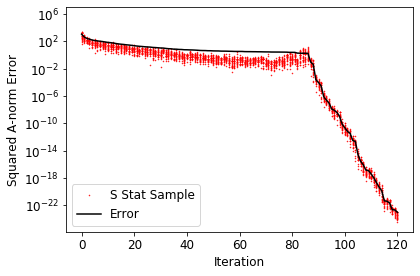

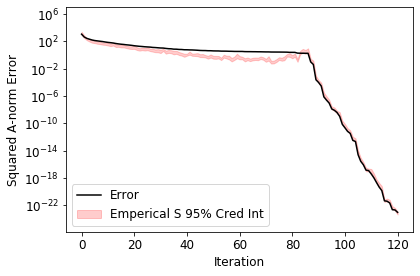

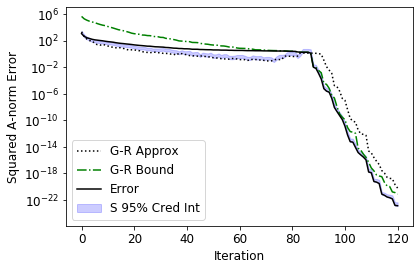

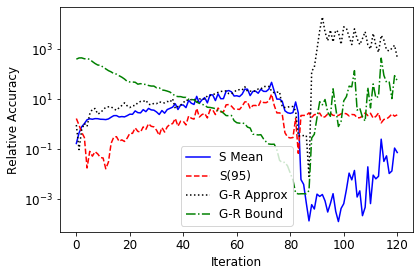

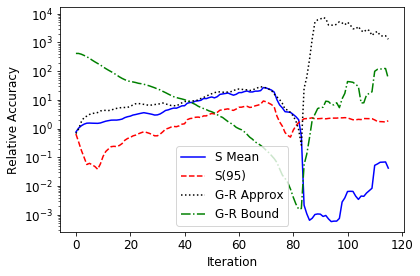

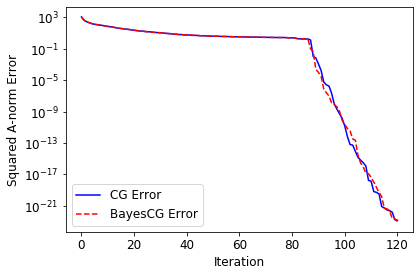

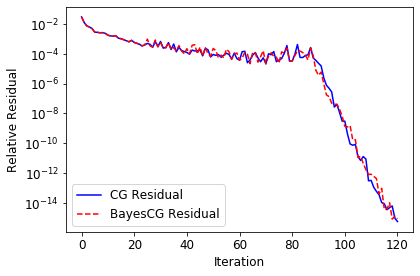

In [3]:
# RUN CELL TWICE TO SET FONT SIZE
plt.rcParams.update({'font.size': 12})

GR = .999*min(SVD_A['S'])

#Delay
d = 4

#Iterations
it = 120

#First iterations to zoom in on
it_z = None

#S statistic samples per iteration
samples = 25

#Percent in credible interval
pct = 95

#Iterations in moving average comparing error estimates
MA = 5

#Whether to reotrhogonalize
reorth = False

# Running the experiments
bayescg_exp_plots(AVec,b,x0,NormA,xTrue,GR,it,it_z,d,samples,pct,MA,reorth,plt_title=False)

'''
plt.figure(1)
plt.savefig('../NumericalSuppImages/48S.pdf')
plt.figure(2)
plt.savefig('../NumericalSuppImages/48Emp.pdf')
plt.figure(3)
plt.savefig('../NumericalSuppImages/48Conv.pdf')
plt.figure(4)
plt.savefig('../NumericalSuppImages/48Acc.pdf')
'''



### Second Experiment

Next, we investigate the error estimates with the $n=11948$ matrix 

#### Setup the problem


In [4]:
A = mmread('bcsstk18_prec.mtx')

N = 11948


def AVec(w):
    return A.dot(w)


xTrue = np.ones(N)
b = AVec(xTrue)
x0 = np.zeros(N)

NormA = None


#### Run the experiment

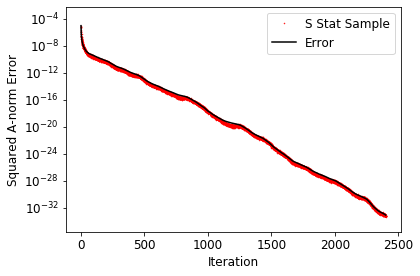

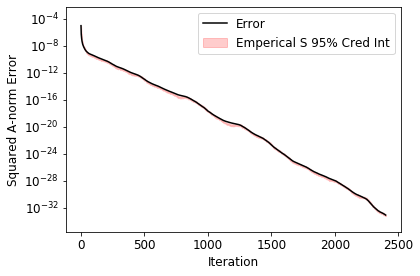

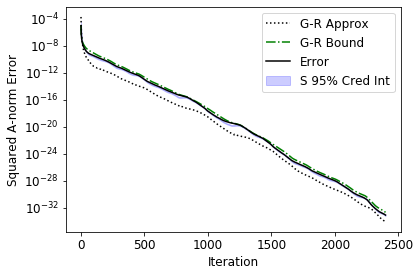

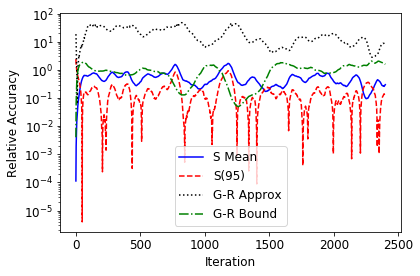

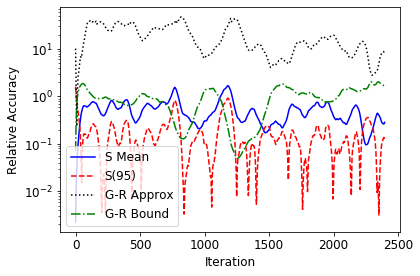

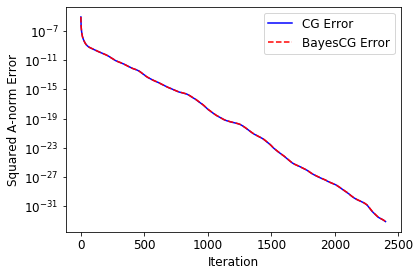

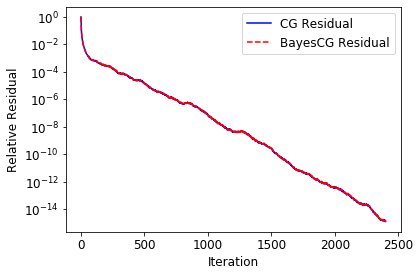

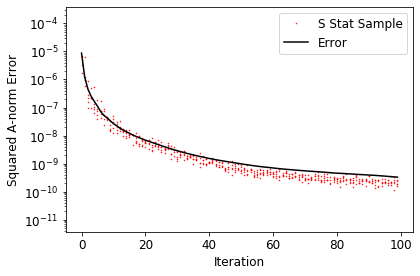

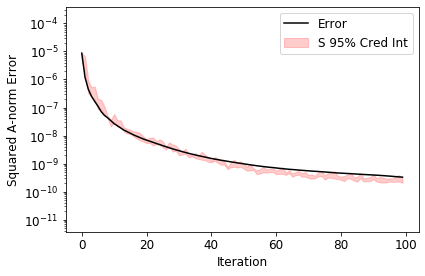

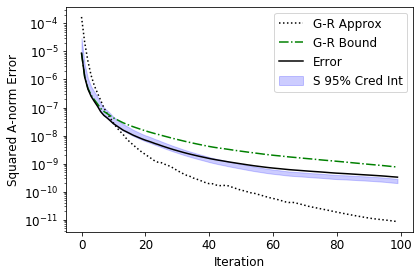

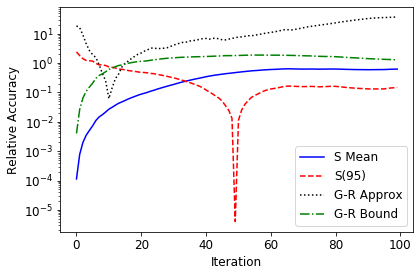

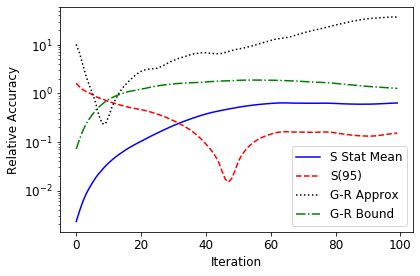

In [5]:
GR = 9e-14

#Delay
d = 50

#Iterations
it = 2400

#First iterations to zoom in on
it_z = 100

#S statistic samples per iteration
samples = 5

#Percent in credible interval
pct = 95

#Iterations in moving average comparing error estimates
MA = 5

#Whether to reotrhogonalize
reorth = False

# Running the experiments
bayescg_exp_plots(AVec,b,x0,NormA,xTrue,GR,it,it_z,d,samples,pct,MA,reorth,plt_title=False)

'''
plt.figure(1)
plt.savefig('../NumericalSuppImages/BigS.pdf')
plt.figure(2)
plt.savefig('../NumericalSuppImages/BigEmp.pdf')
plt.figure(3)
plt.savefig('../NumericalSuppImages/BigConv.pdf')
plt.figure(4)
plt.savefig('../NumericalSuppImages/BigAcc.pdf')
'''


## BayesCG With Different Priors

We examine the performance of BayesCG with different prior covariances on the same $n = 100$ from the main main part of the paper.

#### Setup

In [6]:
np.random.seed(1)

N = 100

A,SVD_A = random_matrix_generator(N,3,2)
CondA = max(SVD_A['S'])/min(SVD_A['S'])
NormA = max(SVD_A['S'])

AInv = SVD_A['U']@np.diag(SVD_A['S']**-1)@SVD_A['U'].T

def AVec(w):
    return A@w

def AInvVec(w):
    return AInv@w

def IVec(w):
    return w

xTrue = np.ones(N)
b = AVec(xTrue)
x0 = np.zeros(N)

Err = xTrue - x0

def ErrVec(w):
    if len(w.shape) == 1:
        return np.inner(Err,w)*Err
    else:
        return np.outer(Err,Err)@w


#### Run the experiment

"\nplt.figure(1)\nplt.savefig('../../NumericalSuppImages/PriorErr.pdf')\nplt.figure(2)\nplt.savefig('../../NumericalSuppImages/PriorRes.pdf')\n"

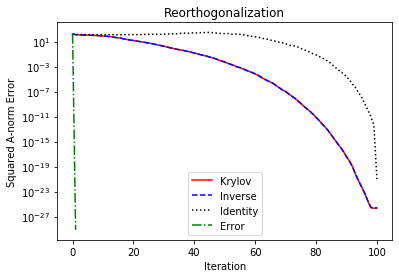

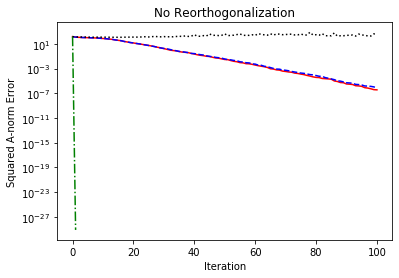

In [7]:
it = 100
reorth = True
delay = 1

_,_,_,info_k = bayescg_k(AVec,b,x0,delay,it,None,1e-150,reorth = reorth,NormA = NormA,xTrue = xTrue)

_,_,info_inv = bayescg(AVec,b,x0,AInvVec,it,None,reorth,NormA,xTrue)

_,_,info_I = bayescg(AVec,b,x0,IVec,it,None,reorth,NormA,xTrue)

it = 1
_,_,info_E = bayescg(AVec,b,x0,ErrVec,it,None,reorth,NormA,xTrue)

errK = info_k['err']
errInv = info_inv['err']
errI = info_I['err']
errE = info_E['err']

green = (0,0.5,0)

plt.figure(1)
plt.semilogy(errK, label = 'Krylov', color = 'r')
plt.semilogy(errInv,'--', label = 'Inverse', color = 'b')
plt.semilogy(errI,':', label = 'Identity', color = 'k')
plt.semilogy(errE,'-.', label = 'Error', color = green)

plt.xlabel('Iteration')
plt.ylabel('Squared A-norm Error')
plt.title('Reorthogonalization')
plt.legend()

reorth = False
it = 100

_,_,_,info_k = bayescg_k(AVec,b,x0,delay,it,None,1e-150,reorth = reorth,NormA = NormA,xTrue = xTrue)

_,_,info_inv = bayescg(AVec,b,x0,AInvVec,it,None,reorth,NormA,xTrue)

_,_,info_I = bayescg(AVec,b,x0,IVec,it,None,reorth,NormA,xTrue)

it = 1
_,_,info_E = bayescg(AVec,b,x0,ErrVec,it,None,reorth,NormA,xTrue)

errK = info_k['err']
errInv = info_inv['err']
errI = info_I['err']
errE = info_E['err']

plt.figure(2)
plt.semilogy(errK, label = 'Krylov', color = 'r')
plt.semilogy(errInv,'--', label = 'Inverse', color = 'b')
plt.semilogy(errI,':', label = 'Identity', color = 'k')
plt.semilogy(errE,'-.', label = 'Error', color = green)

plt.xlabel('Iteration')
plt.ylabel('Squared A-norm Error')
plt.title('No Reorthogonalization')

'''
plt.figure(1)
plt.savefig('../../NumericalSuppImages/PriorErr.pdf')
plt.figure(2)
plt.savefig('../../NumericalSuppImages/PriorRes.pdf')
'''


## Unpreconditioned $n=11948$ matrix

We examine CG error estimation on the unpreconditioned version of the $n=11948$ matrix.

The matrix in this experiment is the sparse matrix "BCSSTK18" from the Matrix Market.

The Gauss-Radau estimate in this experiment is the approximation of the Gauss-Radau upper bound from (Meurant and Tichy, 2019).

We have included a file, "bcsstk18.mtx' that contains the matrix. It can also be found at: (https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/bcsstruc2/bcsstk18.html)

### Setup


In [16]:
A = mmread('bcsstk18.mtx')
N = 11948

def AVec(w):
    return A.dot(w)

GR = None

xTrue = np.ones(N)
b = AVec(xTrue)
x0 = np.zeros(N)


### Run the experiment (Takes a long time)

/Users/timreid/Dropbox/BayesCGKrylov/ProbNumCG-Supp/BayesCGExperiments/plots.py:144: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/timreid/Dropbox/BayesCGKrylov/ProbNumCG-Supp/BayesCGExperiments/plots.py:173: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/timreid/Dropbox/BayesCGKrylov/ProbNumCG-Supp/BayesCGExperiments/plots.py:204: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/anaconda3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend wi

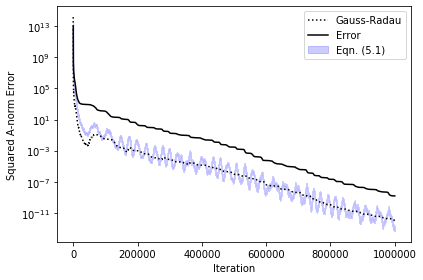

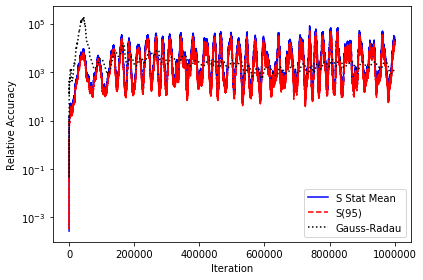

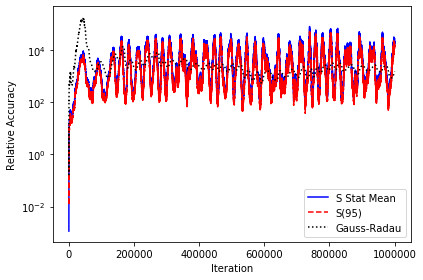

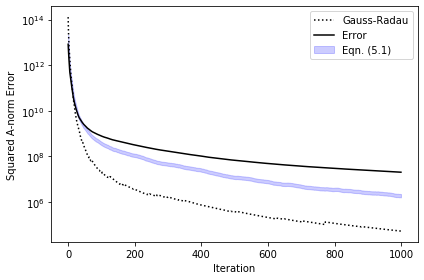

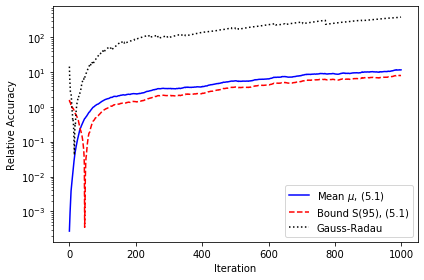

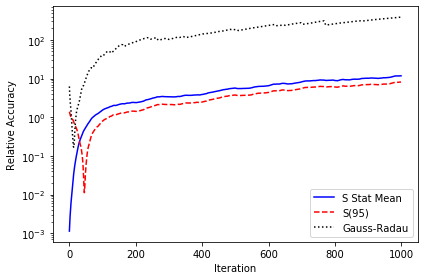

In [17]:
#Delay
d = 50

#Iterations
it = 1000000

#First iterations to zoom in on
it_z = 1000

#S statistic samples per iteration
samples = None

#Percent in credible interval
pct = 95

#Iterations in moving average comparing error estimates
MA = 5

#Whether to reotrhogonalize
reorth = False

# Running the experiments
bayescg_exp_plots(AVec,b,x0,NormA,xTrue,GR,it,it_z,d,samples,pct,MA,reorth,plt_title=False)

'''
plt.figure(3)
plt.savefig('../../NumericalSuppImages/MillionCG.png',dpi=400)

plt.figure(10)
plt.savefig('../../NumericalSuppImages/MillionCG_z.pdf')
plt.figure(11)
plt.savefig('../../NumericalSuppImages/MillionErr_z.pdf')
'''



## Help with the programs

All the included programs have docstrings written for them. You can type "help(FunctionNameHere)" to access the docstrings. See the example below:

In [2]:
help(bayescg_k)

Help on function bayescg_k in module bayescg_k:

bayescg_k(A, b, x, post_rank=5, max_it=None, tol=1e-06, l_tol=1e-32, samples=None, reorth=False, NormA=None, xTrue=None)
    Computes solution to Ax = b with BayesCG with Krylov Prior
    
    This program iteratively solves a symmetric positive definite system 
    of linear equations with a with the Bayesian Conjugate Gradient method
    under the Krylov prior, a probabilistic numerical method. This 
    implementation is based on the Conjugate Gradient method.
            
    Parameters
    ----------
    A : function
        Function that computes the matvec of A
    b : numpy array
        Right hand side vector from equation Ax = b
    x : numpy array
        Initial guess for x in equation Ax = b
    post_rank : int, optional, default is 5
        Rank of Krylov Posterior Covariance
    max_it : int, optional, default is size of A
        Maximum amount of iterations to run
    tol : float, optional, default is 1e-6
        Conve